# Classification cats dogs

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [2]:
#identify constants
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
data_pat='cat'
os.listdir(data_pat)

['test_set', 'training_set']

# Preprocessing data

In [4]:
test=os.listdir('cat/test_set')

In [5]:
train=os.listdir('cat/training_set/')
train

['cats', 'dogs']

In [6]:
categories=[]
filenames=[]
for folder in train:
    file_path = os.path.join('cat/training_set/', folder)
    files = os.listdir(file_path)
    for file in files:
        category = file.split('.')[0]
        if category == 'dog':
            categories.append(1)
            filenames.append(folder+'/'+file)
            
        else:
            categories.append(0)
            filenames.append(folder+'/'+file)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [7]:
df

filename  category
0        cats/cat.1.jpg         0
1       cats/cat.10.jpg         0
2      cats/cat.100.jpg         0
3     cats/cat.1000.jpg         0
4     cats/cat.1001.jpg         0
...                 ...       ...
8002   dogs/dog.996.jpg         1
8003   dogs/dog.997.jpg         1
8004   dogs/dog.998.jpg         1
8005   dogs/dog.999.jpg         1
8006     dogs/_DS_Store         0

[8007 rows x 2 columns]

<AxesSubplot:>

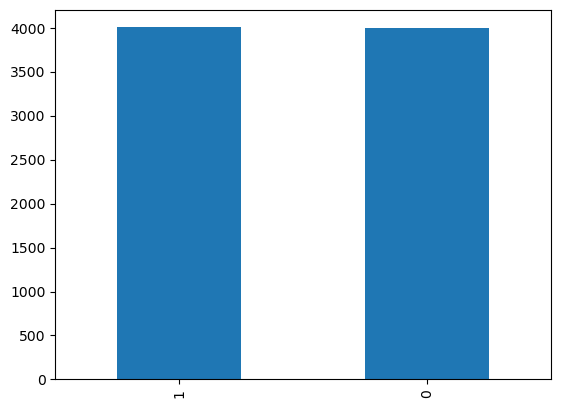

In [8]:
df['category'].value_counts().plot.bar()

We noticed from the graph above that we have an equal quantity of cats(50%) and dogs(50%)

# Sample image

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
img_dataset=image_dataset_from_directory('cat')
data=tf.keras.utils.image_dataset_from_directory('cat')
data_iter=data.as_numpy_iterator()
bat=data_iter.next()

Found 10028 files belonging to 2 classes.
Found 10028 files belonging to 2 classes.


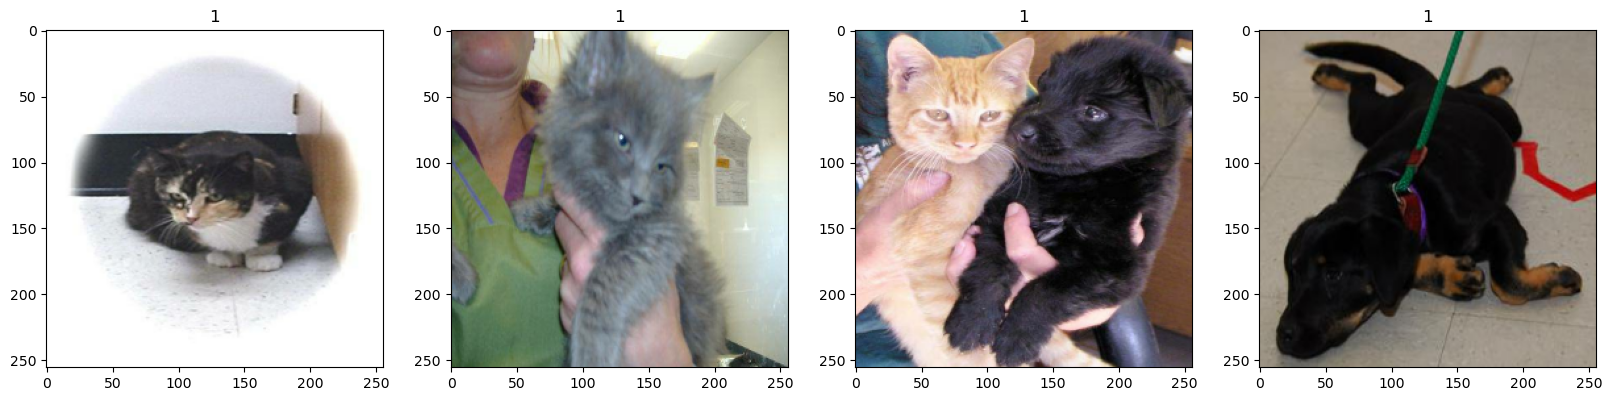

In [10]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for id,img in enumerate(bat[0][:4]):
    ax[id].imshow(img.astype(int))
    ax[id].title.set_text(bat[1][id])

Randomly selected filename: cats/cat.3239.jpg


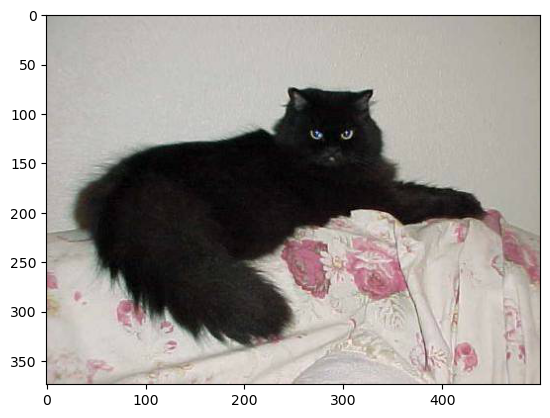

In [11]:
random_filename = random.choice(filenames)
image = load_img("cat/training_set/"+random_filename)
plt.imshow(image)
# Print the result
print("Randomly selected filename:", random_filename)

# Model Training

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

# callbacks

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [14]:
#early stopping
earlystop = EarlyStopping(patience=10)

In [15]:
#Learning Rate Reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [16]:
callbacks = [earlystop, learning_rate_reduction]

In [17]:
#Preparing data
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [18]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [19]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [20]:
#Traning Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "cat/training_set/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 6404 validated image filenames belonging to 2 classes.


In [21]:
train_df.shape

(6405, 2)

In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "cat/training_set/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1601 validated image filenames belonging to 2 classes.


In [23]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "cat/training_set/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


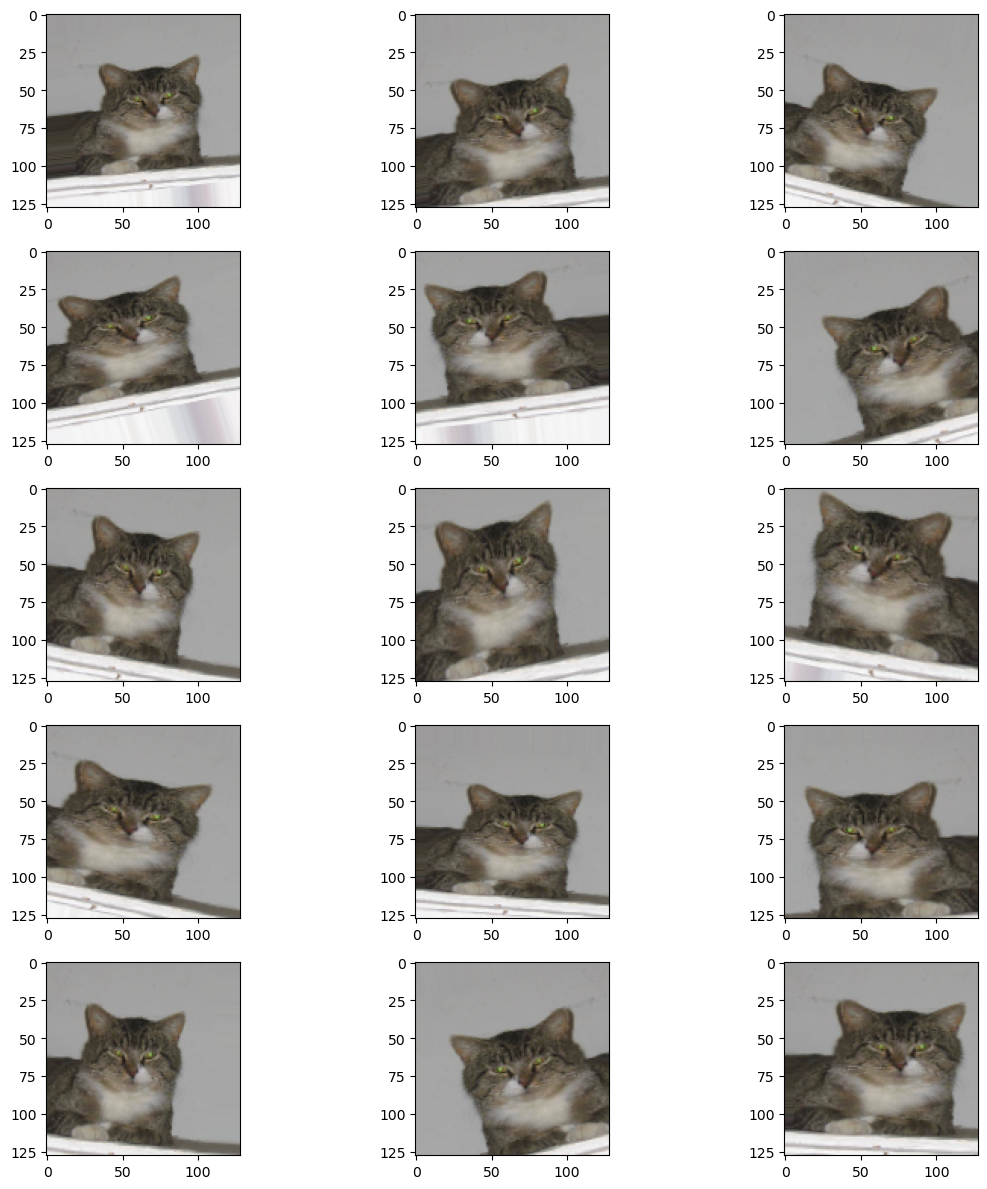

In [24]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [25]:
#fitting model
epochs=3 if FAST_RUN else 10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
427/427 [==============================] - 473s 1s/step - loss: 0.9518 - accuracy: 0.5859 - val_loss: 0.8180 - val_accuracy: 0.5767 - lr: 0.0010
Epoch 2/10
427/427 [==============================] - 553s 1s/step - loss: 0.6725 - accuracy: 0.6373 - val_loss: 0.8598 - val_accuracy: 0.6352 - lr: 0.0010
Epoch 3/10
427/427 [==============================] - 472s 1s/step - loss: 0.6093 - accuracy: 0.6863 - val_loss: 0.6488 - val_accuracy: 0.6472 - lr: 0.0010
Epoch 4/10
427/427 [==============================] - 484s 1s/step - loss: 0.5777 - accuracy: 0.7035 - val_loss: 0.9934 - val_accuracy: 0.5969 - lr: 0.0010
Epoch 5/10
427/427 [==============================] - 413s 967ms/step - loss: 0.5469 - accuracy: 0.7289 - val_loss: 0.4841 - val_accuracy: 0.7679 - lr: 0.0010
Epoch 6/10
427/427 [==============================] - 413s 967ms/step - loss: 0.5302 - accuracy: 0.7456 - val_loss: 1.1270 - val_accuracy: 0.6157 - lr: 0.0010
Epoch 7/10
427/427 [==============================] - 416s

In [40]:
model.save('modelcatdog.h5')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


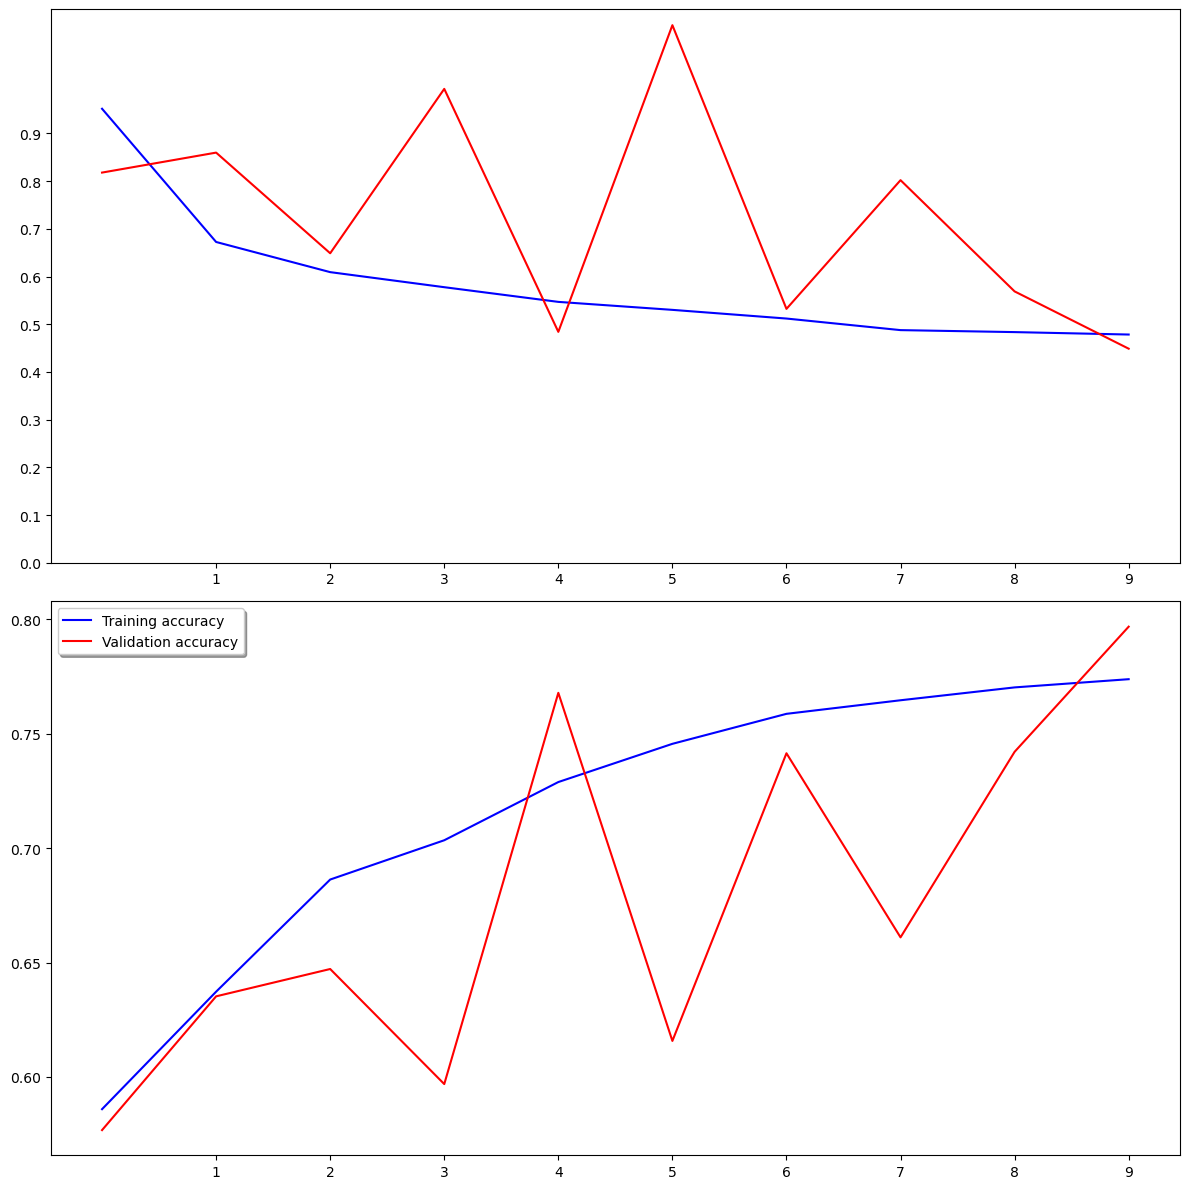

In [41]:
#visualisation training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
plt.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [164]:
#Preparing test data
filenames=[]
for folder in train:
    file_path = os.path.join('cat/test_set/', folder)
    files = os.listdir(file_path)
    for file in files:
            filenames.append(folder+'/'+file)
test_df = pd.DataFrame({
    'filename': filenames,
})
nb_samples = test_df.shape[0]

In [165]:
test_df.shape

(2023, 1)

In [166]:
test_df

filename
0     cats/cat.4001.jpg
1     cats/cat.4002.jpg
2     cats/cat.4003.jpg
3     cats/cat.4004.jpg
4     cats/cat.4005.jpg
...                 ...
2018  dogs/dog.4996.jpg
2019  dogs/dog.4997.jpg
2020  dogs/dog.4998.jpg
2021  dogs/dog.4999.jpg
2022  dogs/dog.5000.jpg

[2023 rows x 1 columns]

In [167]:
#Testing Generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "cat/test_set/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 2023 validated image filenames.


In [168]:
#Predicting
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [169]:
predict.shape

(2023, 2)

In [170]:
test_df.shape

(2023, 1)

In [171]:
predict.shape

(2023, 2)

In [172]:
test_df['category_pred'] = np.argmax(predict, axis=1)
test_df

filename  category_pred
0     cats/cat.4001.jpg              1
1     cats/cat.4002.jpg              1
2     cats/cat.4003.jpg              0
3     cats/cat.4004.jpg              0
4     cats/cat.4005.jpg              0
...                 ...            ...
2018  dogs/dog.4996.jpg              1
2019  dogs/dog.4997.jpg              1
2020  dogs/dog.4998.jpg              0
2021  dogs/dog.4999.jpg              1
2022  dogs/dog.5000.jpg              1

[2023 rows x 2 columns]

In [173]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category_pred'] = test_df['category_pred'].replace(label_map)
test_df

filename category_pred
0     cats/cat.4001.jpg           dog
1     cats/cat.4002.jpg           dog
2     cats/cat.4003.jpg           cat
3     cats/cat.4004.jpg           cat
4     cats/cat.4005.jpg           cat
...                 ...           ...
2018  dogs/dog.4996.jpg           dog
2019  dogs/dog.4997.jpg           dog
2020  dogs/dog.4998.jpg           cat
2021  dogs/dog.4999.jpg           dog
2022  dogs/dog.5000.jpg           dog

[2023 rows x 2 columns]

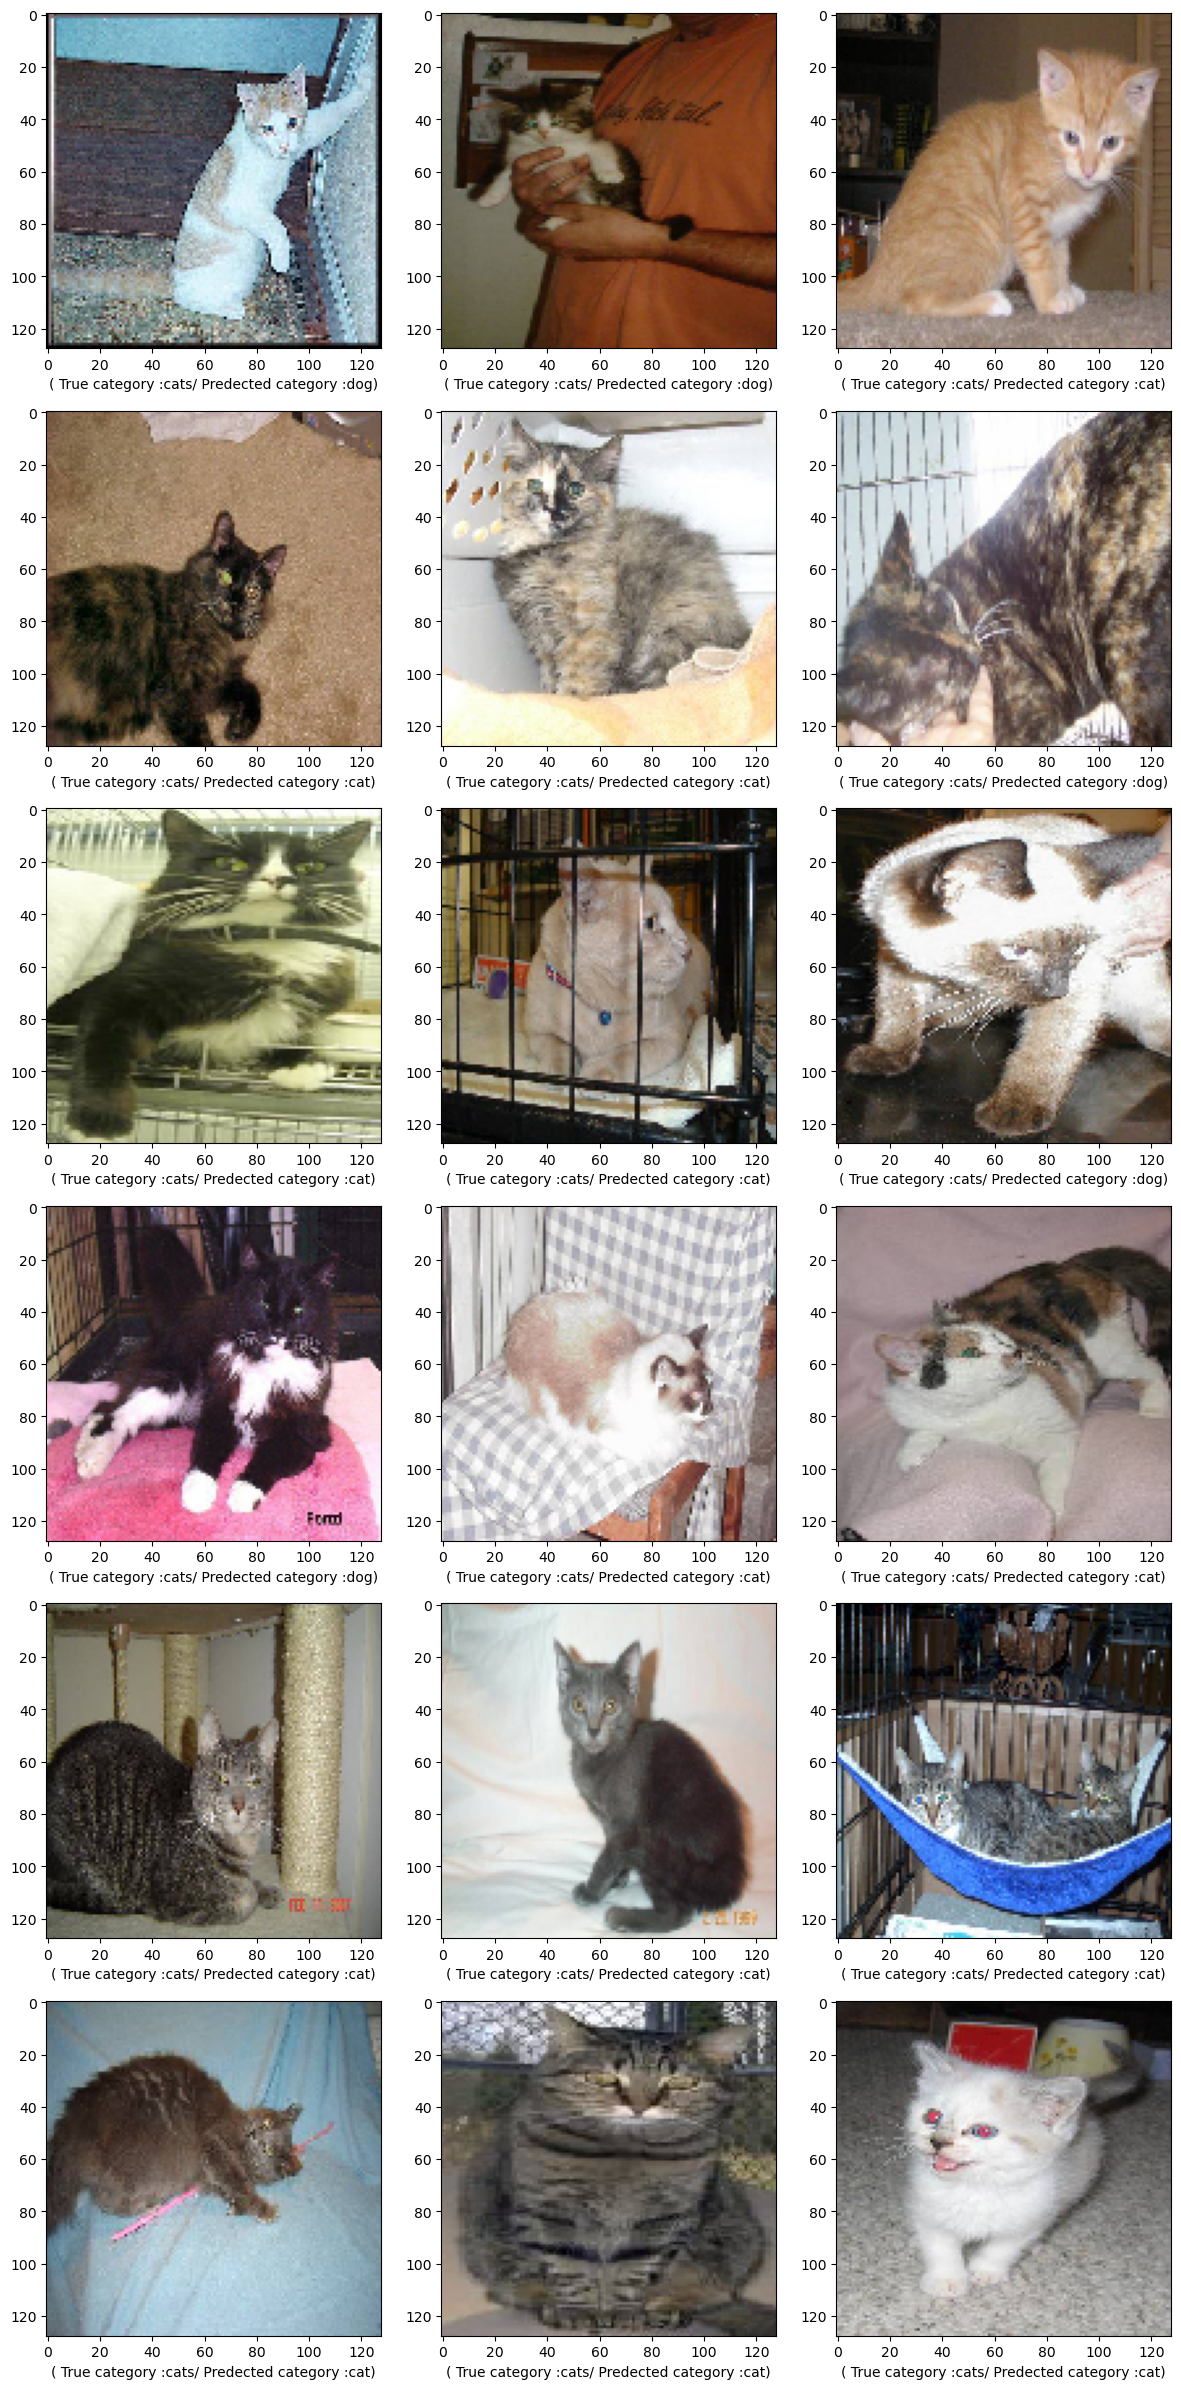

In [184]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    #(filename.split('.')[0])
    category = row['category_pred']
    img = load_img("cat/test_set/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    t=(filename.split('.')[0]).split('/')[0]
    plt.xlabel("( True category :"+ t + '/ Predected category :' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()